In [1]:
import numpy as np
import pandas as pd

from pprint import pprint

from decision_tree_functions import decision_tree_algorithm, make_predictions, calculate_accuracy
from helper_functions import generate_data, create_plot, train_test_split

# 1. Post-Pruning

In [2]:
def filter_df(df, question):
    feature, comparison_operator, value = question.split()
    
    # continuous feature
    if comparison_operator == "<=":
        df_yes = df[df[feature] <= float(value)]
        df_no =  df[df[feature] >  float(value)]
        
    # categorical feature
    else:
        df_yes = df[df[feature].astype(str) == value]
        df_no  = df[df[feature].astype(str) != value]
    
    return df_yes, df_no

In [3]:
def determine_leaf(df_train, ml_task):
    
    if ml_task == "regression":
        return df_train.label.mean()
    
    # classification
    else:
        return df_train.label.value_counts().index[0]

In [4]:
def determine_errors(df_val, tree, ml_task):
    predictions = make_predictions(df_val, tree)
    actual_values = df_val.label
    
    if ml_task == "regression":
        # mean squared error
        return ((predictions - actual_values) **2).mean()
    else:
        # number of errors
        return sum(predictions != actual_values)

In [5]:
def pruning_result(tree, df_train, df_val, ml_task):
    
    leaf = determine_leaf(df_train, ml_task)
    errors_leaf = determine_errors(df_val, leaf, ml_task)
    errors_decision_node = determine_errors(df_val, tree, ml_task)

    if errors_leaf <= errors_decision_node:
        return leaf
    else:
        return tree

In [6]:
def post_pruning(tree, df_train, df_val, ml_task):
    
    question = list(tree.keys())[0]
    yes_answer, no_answer = tree[question]

    # base case
    if not isinstance(yes_answer, dict) and not isinstance(no_answer, dict):
        return pruning_result(tree, df_train, df_val, ml_task)
        
    # recursive part
    else:
        df_train_yes, df_train_no = filter_df(df_train, question)
        df_val_yes, df_val_no = filter_df(df_val, question)
        
        if isinstance(yes_answer, dict):
            yes_answer = post_pruning(yes_answer, df_train_yes, df_val_yes, ml_task)
            
        if isinstance(no_answer, dict):
            no_answer = post_pruning(no_answer, df_train_no, df_val_no, ml_task)
        
        tree = {question: [yes_answer, no_answer]}
    
        return pruning_result(tree, df_train, df_val, ml_task)

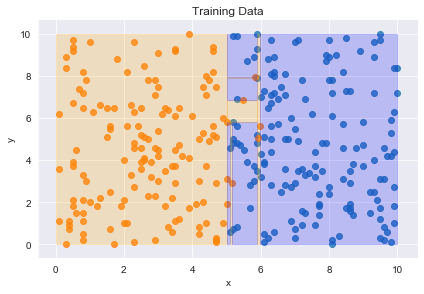

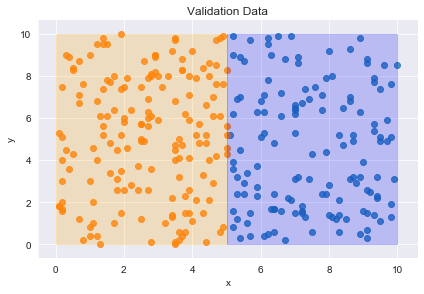

In [7]:
# np.random.seed(0)
df_train = generate_data(n=300, n_random_outliers=5)
tree = decision_tree_algorithm(df_train, ml_task="classification", max_depth=10)
create_plot(df_train, tree, title="Training Data")

# np.random.seed(7)
df_val = generate_data(n=300)
tree_pruned = post_pruning(tree, df_train, df_val, ml_task="classification")
create_plot(df_val, tree_pruned, title="Validation Data")